## Check Device

In [1]:
import torch

device = (
    "cuda" if torch.cuda.is_available()
    # else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} as backend.")

if device == "cuda":
  !nvidia-smi

Using cpu as backend.


## Prepare Train and Validate Data

In [2]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader


def diodeClipper_dataset_load(N, Fs, num_up, num_down, r_begin, r_end):
    r_begin_str = f"{r_begin / 1000:.2f}k"
    r_end_str = f"{r_end / 1000:.2f}k"
    Fs_str = f"{Fs / 1000:.1f}k"

    data_path = ("./LTspice_data" +
                 f"/{num_up}u{num_down}d" + "/diode_clipper" + f"_{num_up}u{num_down}d" +
                 f"_{r_begin_str}" + f"_{r_end_str}" + f"_{Fs_str}"
                 )

    v_i_path = data_path + "_i.wav"
    v_o_path = data_path + "_o.wav"
    r_path = data_path + "_r.wav"

    v_i, _ = librosa.load(path=v_i_path, sr=None, mono=True)
    v_o, _ = librosa.load(path=v_o_path, sr=None, mono=True)
    r, _ = librosa.load(path=r_path, sr=None, mono=True)

    if len(v_i) != len(v_o):
        raise ValueError("The length of v_in and v_out are not same!")
    if len(v_i) != len(r):
        raise ValueError("The length of v_in and r are not same!")

    if N <= len(v_i):
        v_i = v_i[:N]
        v_o = v_o[:N]
        r   = r  [:N]
    else:
        raise ValueError("The N must be less or equal than the length of audio files.")

    v_i = v_i * 2
    r = r_begin + (r_end - r_begin) * r
    Fs = np.ones_like(v_i) * Fs
    return np.stack((v_i, r, Fs), axis=-1), v_o


def get_diodeClipper_dataloader(N, Fs=None, num_up=1, num_down=1, r_begin: float = 10e3, r_end: float = 100e3,
                                batch_size=16, split_ratio=0.8, shuffle=True, random_state=42, plot=False):
    if Fs is None:
        Fs = [48e3]

    x, y = [], []
    for Fs in Fs:
        v_i_r, v_o = diodeClipper_dataset_load(N, Fs, num_up, num_down, r_begin, r_end)
        x.extend(v_i_r)
        y.extend(v_o)
    x = np.array(x).squeeze()
    y = np.array(y).squeeze()

    num_batches = int(len(x) / batch_size)
    x_batched = x[:num_batches * batch_size].reshape(num_batches, batch_size, 3)
    y_batched = y[:num_batches * batch_size].reshape(num_batches, batch_size)

    x_train, x_valid, y_train, y_valid = train_test_split(
        x_batched, y_batched,
        train_size=split_ratio,
        shuffle=shuffle,
        random_state=random_state
    )

    train_ds = TensorDataset(
        torch.tensor(x_train, dtype=torch.float32).to(device),
        torch.tensor(y_train, dtype=torch.float32).to(device),
    )
    valid_ds = TensorDataset(
        torch.tensor(x_valid, dtype=torch.float32).to(device),
        torch.tensor(y_valid, dtype=torch.float32).to(device)
    )

    train_dl = DataLoader(train_ds, shuffle=shuffle)
    valid_dl = DataLoader(valid_ds)

    if plot:
        v_in = x[:, 0]
        r_in = x[:, 1]
        v_out = y

        fig, ax1_1 = plt.subplots(figsize=(10, 5))

        line1, = ax1_1.plot(v_in, label='v_in')
        line2, = ax1_1.plot(v_out, label='v_out')
        ax1_1.set_ylim((-2.0, 2.0))

        ax1_1.set_title("LTspice Data")
        ax1_1.set_xlabel('Samples [n]')
        ax1_1.set_ylabel('Voltage [V]')

        ax1_2 = ax1_1.twinx()
        line3, = ax1_2.plot(r_in, color='r', label='R_in')
        ax1_2.set_ylabel('Resistor [Ω]')
        ax1_2.set_ylim((r_begin, r_end))
        ax1_2.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

        lines = [line1, line2, line3]
        labels = [line.get_label() for line in lines]
        ax1_1.legend(lines, labels, loc='upper right')

        plt.show()

        # 保存为矢量图
        fig.savefig(f'LTspice_data_{num_up}u{num_down}d.pdf', format='pdf')  # PDF格式

    return train_dl, valid_dl

## Neural Diode Clipper Model

In [3]:
from scipy.special import wrightomega

def diode_pair_lambert(a, R, num_up, num_down, model=None):
    Is = 50e-9
    eta = 1.0
    Vt = 25.8563e-3 * eta

    if model == "1N4148":
        Is = 2.52e-9
        eta = 1
        Vt = 25.8563e-3 * eta

    lambda_ = np.sign(a)
    mu_0 = np.where(a >= 0, num_down, num_up)
    mu_1 = np.where(a >= 0, num_up,   num_down)

    arg_f = np.log((Is * R) / (mu_0 * Vt)) + (lambda_ * a) / (mu_0 * Vt)
    arg_r = np.log((Is * R) / (mu_1 * Vt)) - (lambda_ * a) / (mu_1 * Vt)
    b = a - 2 * Vt * lambda_ * (mu_0 * wrightomega(arg_f) - mu_1 * wrightomega(arg_r))
    return b

In [24]:
import torch
from torch import nn
from typing import Callable


class DiodePair(nn.Module):
    def __init__(self, num_layers: int = 4, layer_size: int = 32, input_size: int = 2, output_size: int = 1, activation_fn: Callable = torch.relu):
        super().__init__()
        self.num_layers = num_layers
        self.layer_size = layer_size
        self.activation_fn = activation_fn

        self.input_layer = nn.Linear(input_size, layer_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(layer_size, layer_size) for _ in range(num_layers-1)])
        self.output_layer = nn.Linear(layer_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.activation_fn(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            y = self.activation_fn(hidden_layer(y))
        y = self.output_layer(y)
        return y


class NDC(nn.Module):
    def __init__(self, fs: float = 48e3, c1: float = 4.7e-9, vs_r: float = 10e3,
                 dp_path=None, num_layers: int = 2, layer_size: int = 16):
        super().__init__()
        self.fs = torch.tensor(fs, dtype=torch.float32)
        self.c1 = torch.tensor(c1, dtype=torch.float32)

        self.vs_r = torch.tensor(vs_r, dtype=torch.float32)
        self.c1_r = None
        self.p1_r = None
        self.p1_g = None
        self.p1 = None

        self.dp = torch.load(dp_path) if dp_path else DiodePair(num_layers=num_layers, layer_size=layer_size)
        self.dp_r = None

        self.update_parameter()

        self.dp = torch.load(dp_path) if dp_path else DiodePair(num_layers=num_layers, layer_size=layer_size)

    def set_states(self, vs_r, fs):
        self.vs_r = vs_r
        self.fs = fs
        self.update_parameter()

    def update_parameter(self):
        # Update impedance of c1
        self.c1_r = 1 / (2 * self.c1 * self.fs)

        # Update parameters of parallel adaptor
        self.p1_r = torch.stack([(self.c1_r * self.vs_r) / (self.c1_r + self.vs_r), self.c1_r, self.vs_r])
        self.p1_g = torch.reciprocal(self.p1_r)
        self.p1 = (2 / torch.sum(self.p1_g)) * torch.ones(3, 1) @ self.p1_g.unsqueeze(0) - torch.eye(3)

        # Update parameter of input impedance of diode pair
        self.dp_r = (self.p1_r[0] - 1.7e3) / (2.5e3 - 1.7e3)

    def forward(self, v_in, vs_r, fs):
        # waves initiate
        output = torch.zeros_like(v_in)
        p1_a = torch.zeros(3, dtype=torch.float32)
        p1_b = torch.zeros(3, dtype=torch.float32)

        for i in range(len(v_in)):
            self.set_states(vs_r[i], fs[i])

            # Forward Scan
            p1_a[1] = p1_b[1]
            p1_a[2] = v_in[i]
            p1_b[0] = self.p1[0] @ p1_a

            # Local Root Scattering
            dp_a = p1_b[0]
            # dp_b = self.dp(torch.stack([dp_a.squeeze(), self.dp_r])).squeeze(0)
            dp_b = torch.tensor(diode_pair_lambert(dp_a.numpy(), self.dp_r.numpy(), num_up=1, num_down=1, model='1N4148'))

            # Backward Scan
            p1_a[0] = dp_b
            p1_b[1] = self.p1[1] @ p1_a
            p1_b[2] = self.p1[2] @ p1_a

            # Read Output
            output[i] = (dp_a + dp_b) / 2

        return output

## Fine-tune Diode Clipper Model

In [5]:
import os
import glob
import time
import torch


def impedance_lookup(fs):
    fs_lookup = {
        tuple([44.1e3]): (1.7e3, 2.5e3),
        tuple([48e3]): (1.7e3, 2.5e3),
        tuple([44.1e3, 48e3]): (1.7e3, 2.5e3),
        tuple([88.2e3]): (0.9e3, 1.3e3),
        tuple([96e3]): (0.9e3, 1.3e3),
        tuple([88.2e3, 96e3]): (0.9e3, 1.3e3),
        tuple([176.4e3]): (0.45e3, 0.65e3),
        tuple([192e3]): (0.45e3, 0.65e3),
        tuple([176.4e3, 192e3]): (0.45e3, 0.65e3),
    }
    return fs_lookup.get(tuple(fs), (0.4e3, 3.0e3))


def get_model_path(path_root="pre_trained_models", circuit_type="dp", num_up: int = 1, num_down: int = 1,
                   diode_type="1N4148", data_type="l", fs=None, num_layers=2, layer_size=16):
    pre_models_path = os.path.join(path_root, f"{num_up}u{num_down}d")
    circuit_type = (
        f"diode_pair_{num_up}u{num_down}d" if circuit_type == "dp" else
        f"diode_clipper_{num_up}u{num_down}d"
    )

    fs = [44.1e3, 48e3] if fs is None else fs
    impedance_begin, impedance_end = impedance_lookup(fs)
    impedance = f"{impedance_begin / 1e3 :.2f}k_{impedance_end / 1e3 :.2f}k"

    network_size = f"{num_layers}x{layer_size}"

    model_name = "_".join([circuit_type, diode_type, data_type, impedance, network_size, "*.pth"])
    model_path = os.path.join(pre_models_path, model_name)
    return glob.glob(model_path)[0]


def train_epoch(model, train_dl, loss_func, skip_size, optimizer, train_mode=True):
    model.train()
    total_loss, total_samples = 0.0, 0
    for x, y in train_dl:
        x = x.squeeze()
        v_in = x[:, 0]
        r_in = x[:, 1]
        fs_in = x[:, 2]

        pred = model(v_in, r_in, fs_in)
        loss = loss_func(pred[skip_size:], y.squeeze()[skip_size:])
        total_loss += loss.item() * x.size(0)
        total_samples += x.size(0)

        if train_mode:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return total_loss / total_samples


def eval_model(model, valid_dl, loss_func, skip_size):
    model.eval()
    total_loss, total_samples = 0.0, 0
    with torch.no_grad():
        for x, y in valid_dl:
            x = x.squeeze()
            v_in = x[:, 0]
            r_in = x[:, 1]
            fs_in = x[:, 2]

            pred = model(v_in, r_in, fs_in)
            loss = loss_func(pred[skip_size:], y.squeeze()[skip_size:])
            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)
    return total_loss / total_samples


def save_model(model, path_root, pre_loss, fine_tuned_loss):
    pre_loss_str = f"{pre_loss:.2e}"
    path_save = dp_path + f"_{loss_str}" + ".pth"
    torch.save(model, path_save)
    print(f"Save model to {path_save}")


def run_model(model, train_dl, valid_dl, epochs, loss_func, skip_size, optimizer, scheduler, train_mode):
    start_time = time.time()
    print("               [Train loss]    [Eval loss]     [Time left]")
    print("----------------------------------------------------------")
    train_losses, valid_losses = [], []

    for epoch in range(epochs):
        start_time_epoch = time.time()
        train_loss = train_epoch(model, train_dl, loss_func, skip_size, optimizer, train_mode)
        valid_loss = eval_model(model, valid_dl, loss_func, skip_size)
        scheduler.step(valid_loss)
        end_time_epoch = time.time()

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f"Epoch {epoch+1:>5d}\t\t{train_loss:>8.4e}\t\t{valid_loss:>8.4e}\t\t{(end_time_epoch-start_time_epoch)/60*(epochs-epoch-1):>.2f} min")

        # torch.save(model, f"checkpoint_epoch_{epoch}.pth")

    end_time = time.time()
    print(f"\nTime cost：{(end_time - start_time)/60:>.2f} min")

    return train_losses, valid_losses

fine_tuned_models/diode_pair_1u1d_1N4148_l_1.70k_2.50k_2x16_1.41e-04_f_5.62e-05x.pth


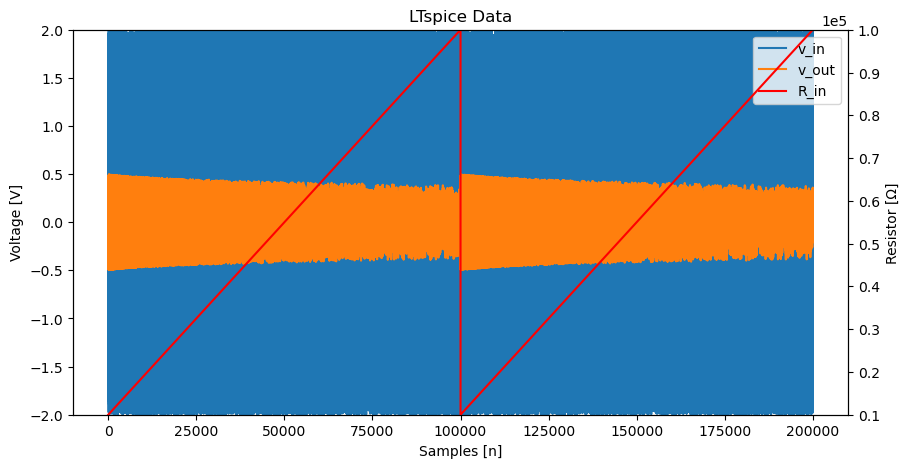

               [Train loss]    [Eval loss]     [Time left]
----------------------------------------------------------
Epoch     1		6.7364e-04		6.8785e-04		27.79 min


KeyboardInterrupt: 

In [25]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


num_up = 1
num_down = 1

N = int(100e3)
fs = [44.1e3, 48e3]

num_layers = 2
layer_size = 16

r_begin = 10e3
r_end   = 100e3

batch_size = 16
skip_size = 50
real_batch_size = batch_size + skip_size

epochs = 100

# dp_path = get_model_path(circuit_type="dp", num_up=num_up, num_down=num_down, data_type="l", fs=fs,num_layers=num_layers, layer_size=layer_size)
dp_path = 'fine_tuned_models/diode_pair_1u1d_1N4148_l_1.70k_2.50k_2x16_1.41e-04_f_5.62e-05x.pth'
print(dp_path)

model = NDC(dp_path=dp_path).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
scheduler = ReduceLROnPlateau(optimizer, factor=0.33,  patience=5, verbose=True)
train_dl, valid_dl = get_diodeClipper_dataloader(N, fs, num_up, num_down, r_begin, r_end,
                                                 batch_size=real_batch_size, plot=True)
train_losses, valid_losses = run_model(model, train_dl, valid_dl, epochs, loss_func, skip_size, optimizer, scheduler, train_mode=False)

In [67]:
torch.save(model.dp, "fine_tuned_models/diode_pair_1u1d_1N4148_l_1.70k_2.50k_3x32_9.82e-05f_5.30e-05.pth")

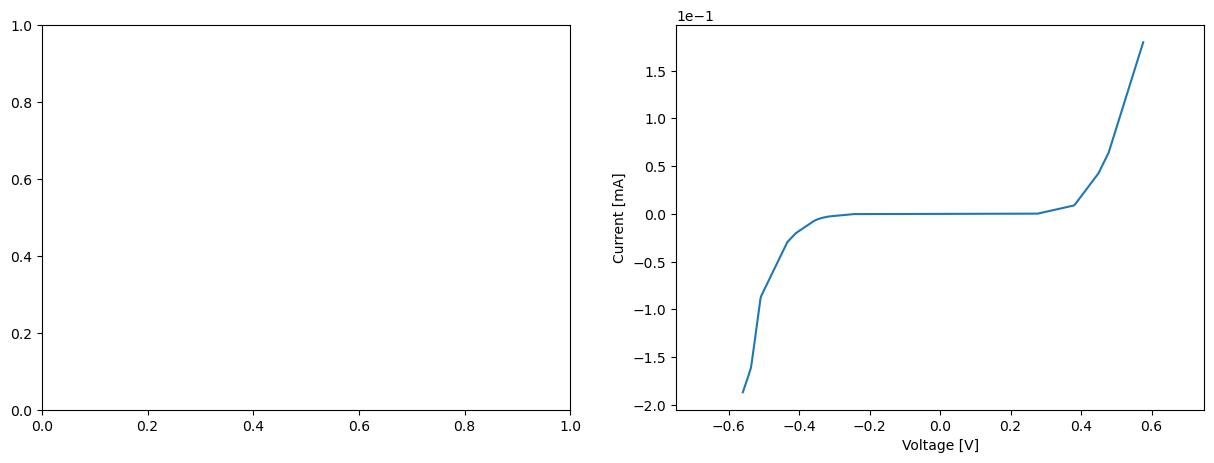

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ax1.plot(train_losses, label='Train Loss')
# ax1.plot(valid_losses, label='Valid Loss')
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Loss (Log Scale)')
# ax1.set_yscale('log')
# ax1.legend()

with torch.no_grad():
    a = torch.linspace(-1, 1, 1000)

    r = 2355
    r_log = torch.ones_like(a) * torch.tensor(r) / 3e3

    b = model.dp(torch.stack([a, r_log], dim=1))
    a = a.detach().numpy().reshape(-1, 1)
    b = b.detach().numpy()
    v = (a + b) / 2
    i = (a - b) / (2*r)

ax2.plot(v, i*1e3)
ax2.set_xlabel('Voltage [V]')
ax2.set_ylabel('Current [mA]')
ax2.set_xlim(-0.75, 0.75)
# ax2.set_ylim(-1, 1)
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

Fs: 48000.0
R: 39.3k


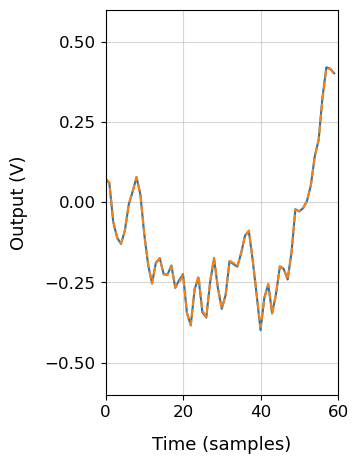

Fs: 44100.0
R: 46.3k


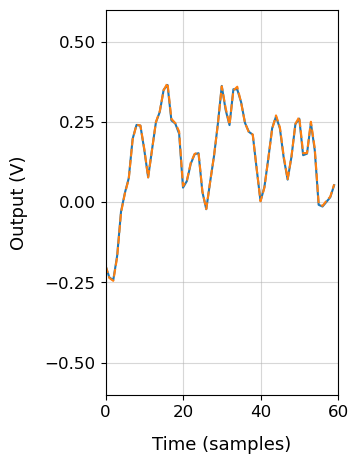

Fs: 48000.0
R: 68.6k


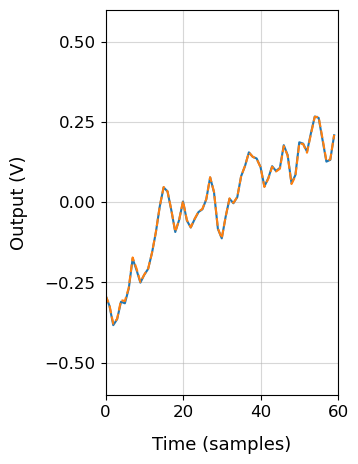

Fs: 44100.0
R: 24.9k


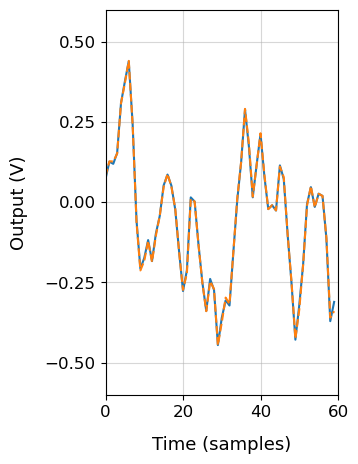

Fs: 48000.0
R: 61.8k


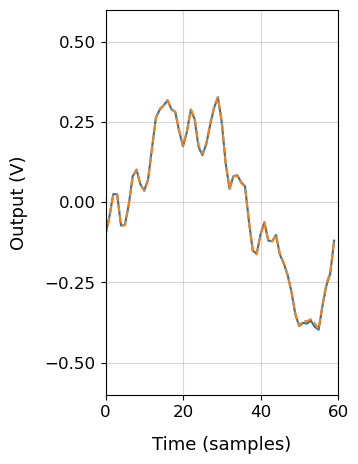

Fs: 44100.0
R: 33.5k


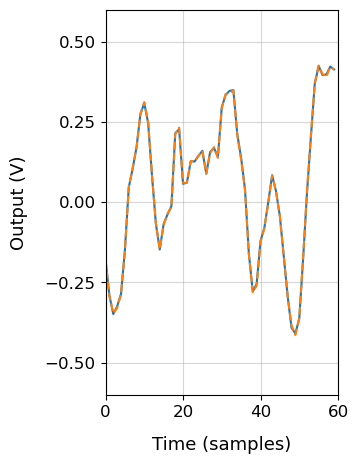

Fs: 44100.0
R: 24.6k


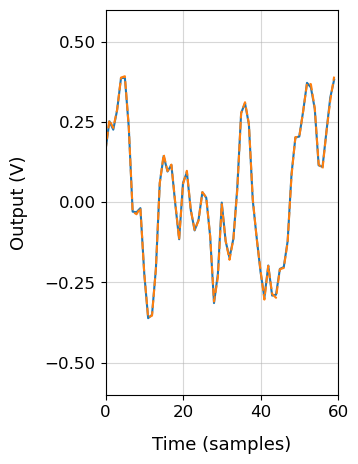

Fs: 44100.0
R: 91.9k


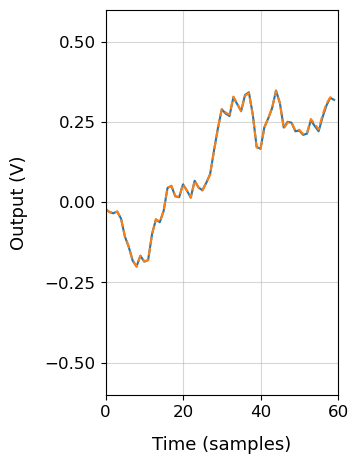

Fs: 48000.0
R: 27.0k


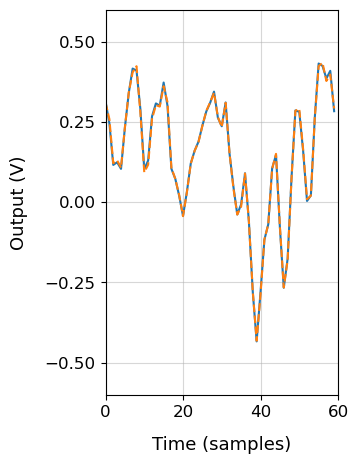

Fs: 48000.0
R: 21.8k


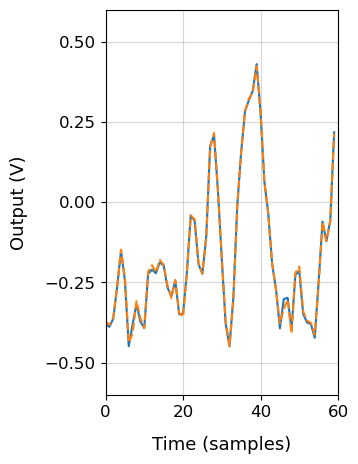

Fs: 44100.0
R: 33.8k


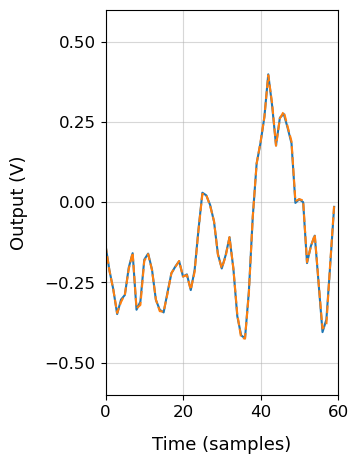

Fs: 48000.0
R: 35.4k


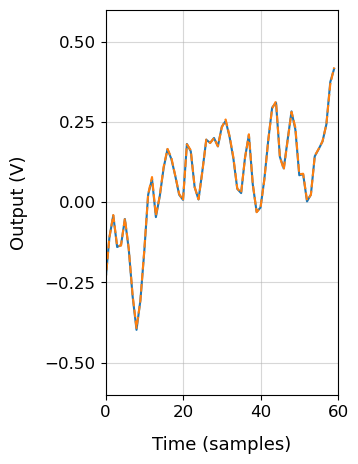

Fs: 48000.0
R: 31.2k


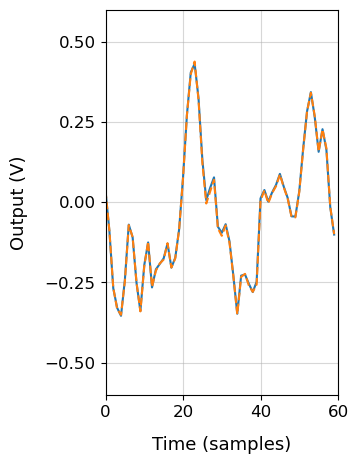

Fs: 44100.0
R: 53.9k


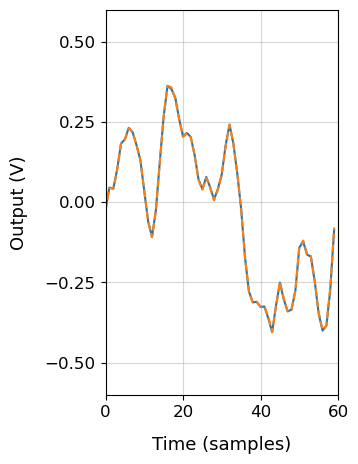

Fs: 48000.0
R: 82.4k


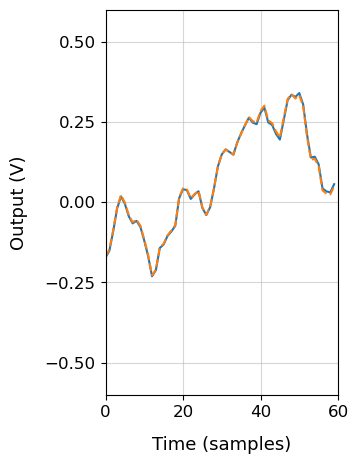

Fs: 44100.0
R: 18.7k


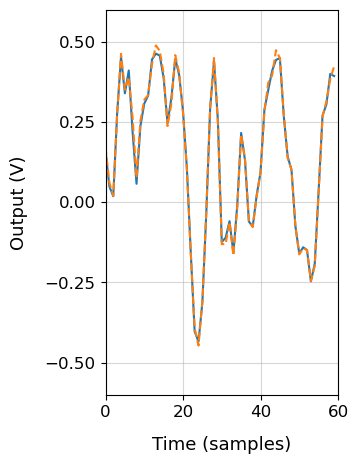

Fs: 48000.0
R: 35.2k


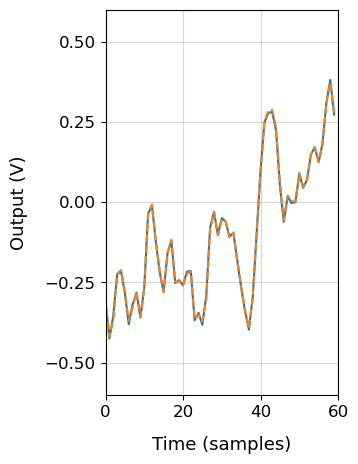

Fs: 44100.0
R: 28.1k


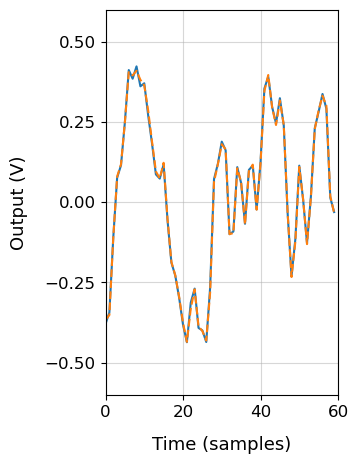

Fs: 48000.0
R: 87.4k


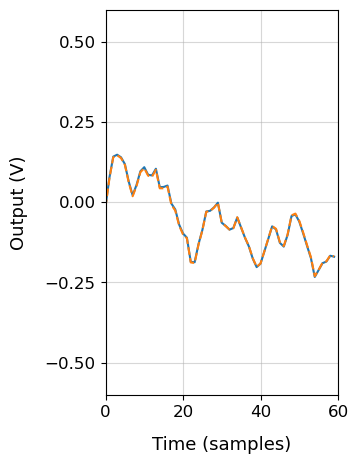

Fs: 44100.0
R: 69.7k


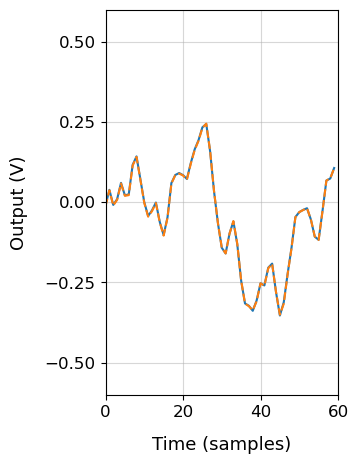

Fs: 44100.0
R: 42.4k


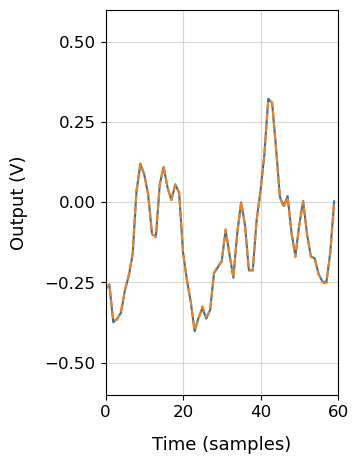

Fs: 44100.0
R: 61.6k


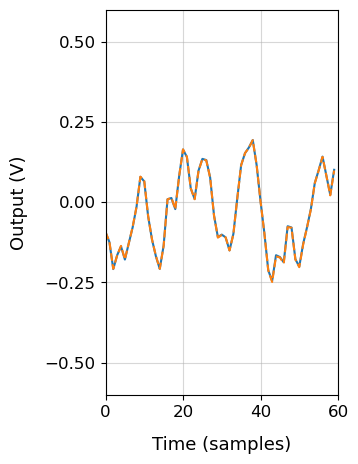

Fs: 48000.0
R: 38.4k


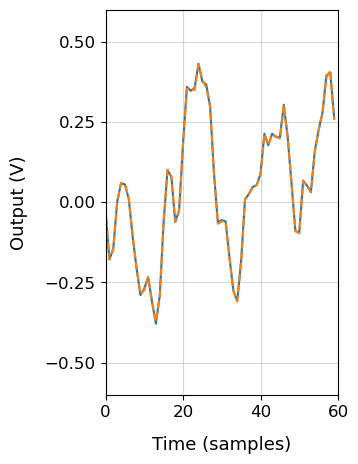

Fs: 44100.0
R: 79.6k


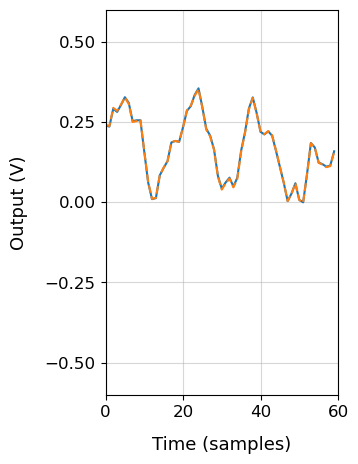

Fs: 48000.0
R: 88.4k


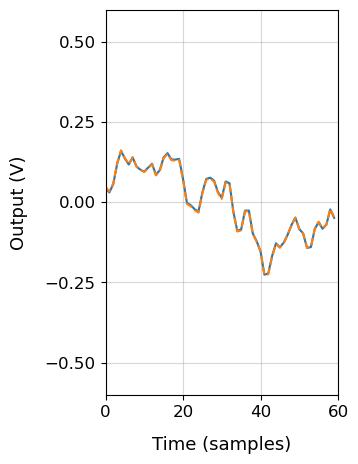

Fs: 44100.0
R: 70.9k


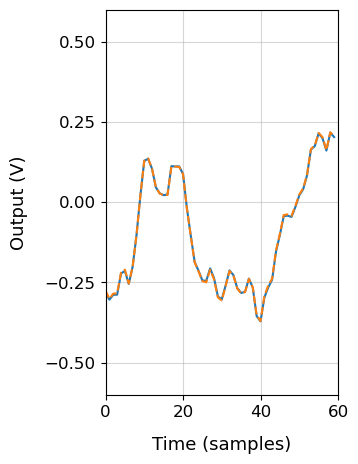

Fs: 48000.0
R: 12.2k


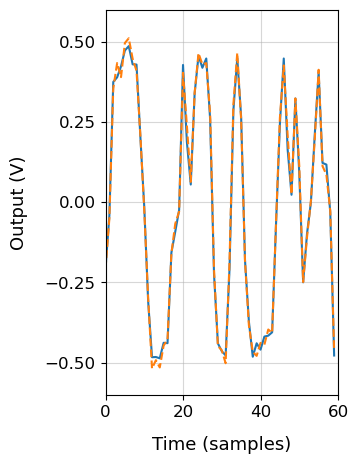

Fs: 44100.0
R: 60.3k


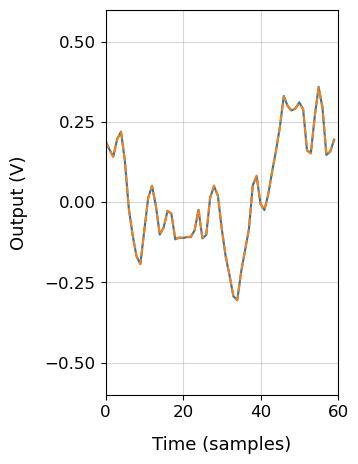

Fs: 48000.0
R: 71.8k


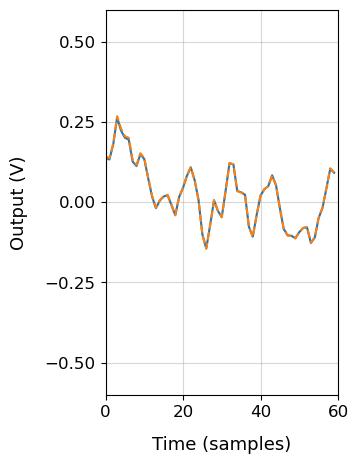

Fs: 44100.0
R: 69.2k


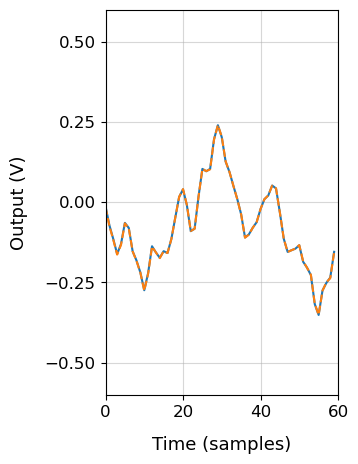

Fs: 44100.0
R: 78.3k


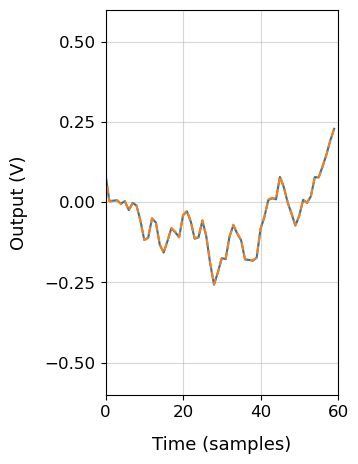

Fs: 44100.0
R: 54.7k


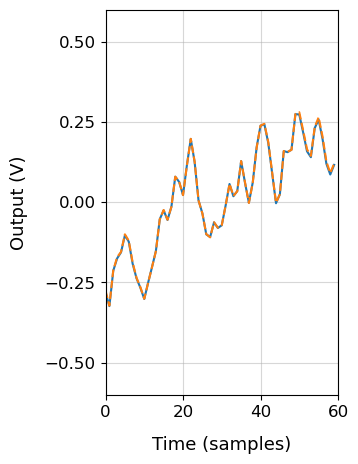

Fs: 44100.0
R: 88.7k


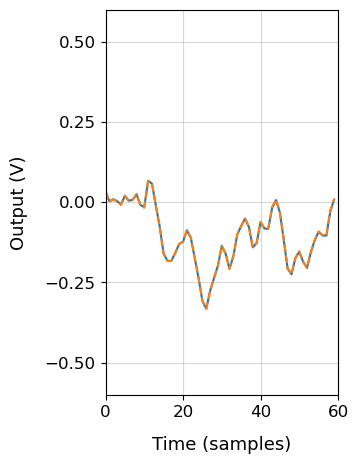

Fs: 48000.0
R: 69.7k


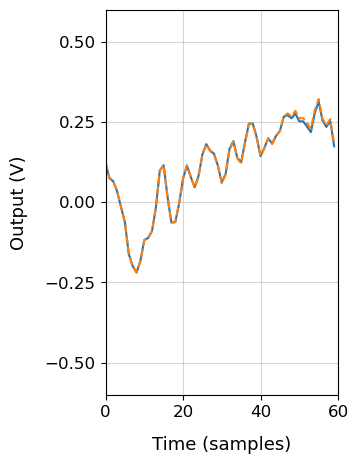

Fs: 44100.0
R: 84.2k


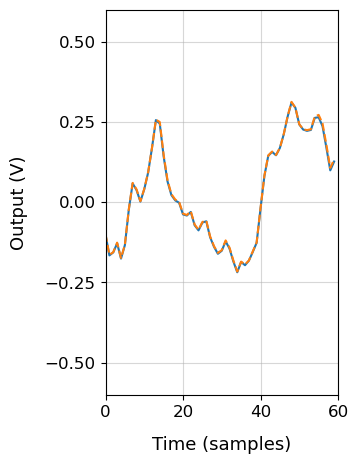

Fs: 48000.0
R: 91.6k


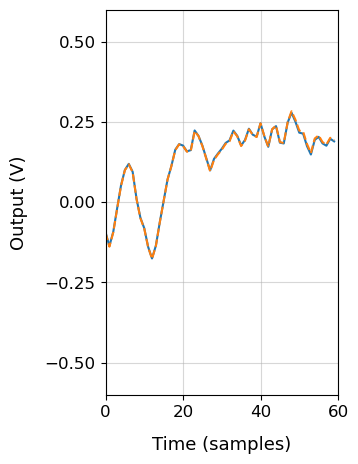

Fs: 44100.0
R: 15.3k


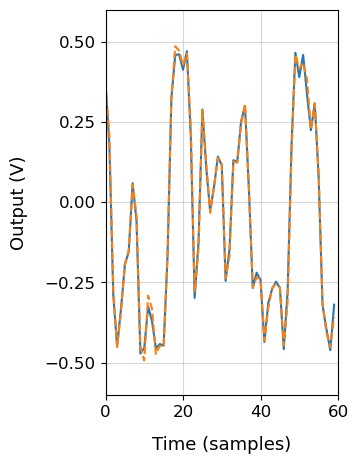

Fs: 44100.0
R: 91.7k


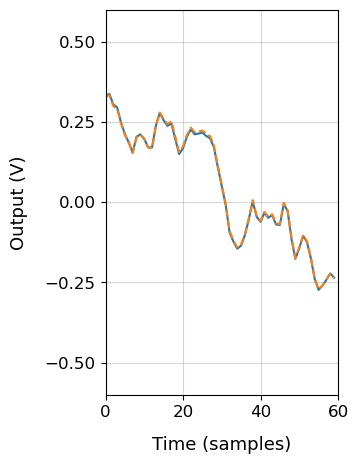

Fs: 44100.0
R: 84.5k


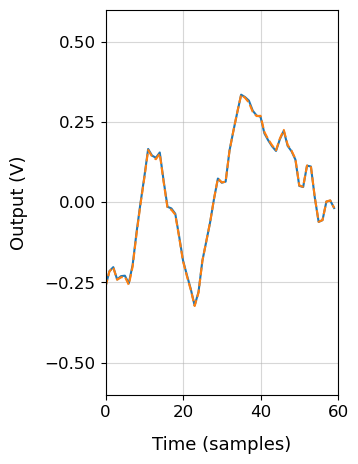

Fs: 44100.0
R: 21.9k


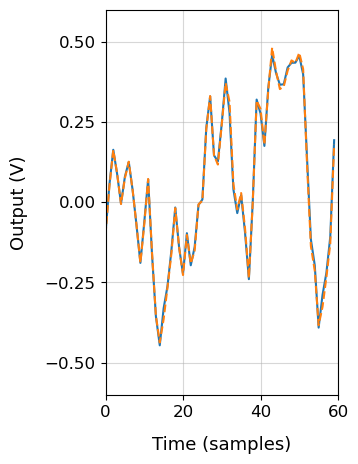

Fs: 48000.0
R: 24.5k


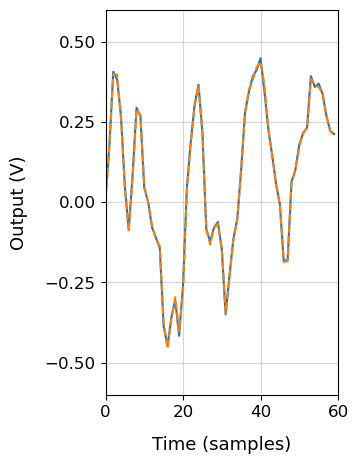

Fs: 48000.0
R: 85.0k


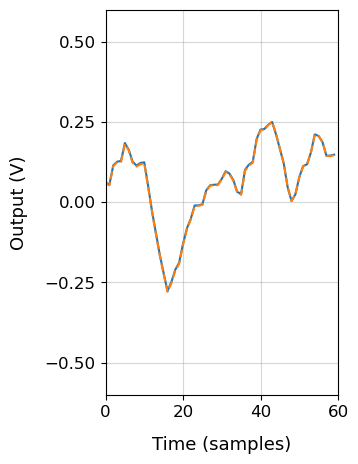

Fs: 44100.0
R: 49.0k


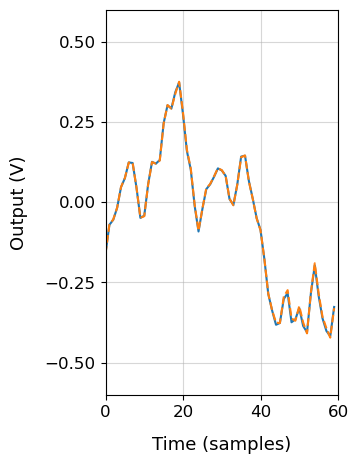

Fs: 48000.0
R: 33.7k


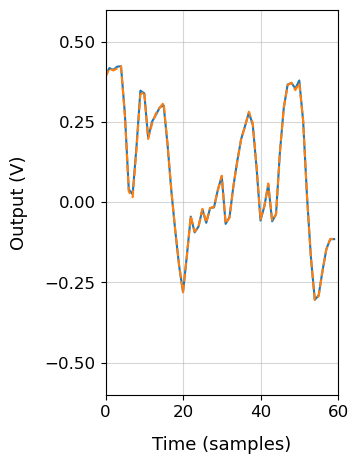

Fs: 48000.0
R: 88.1k


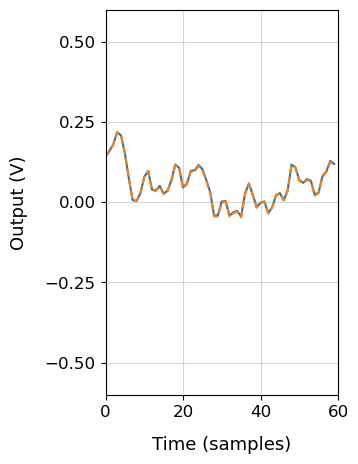

Fs: 48000.0
R: 44.5k


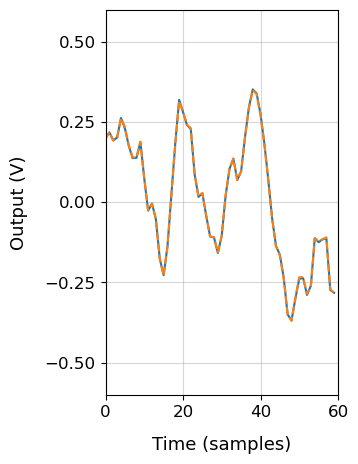

Fs: 48000.0
R: 92.5k


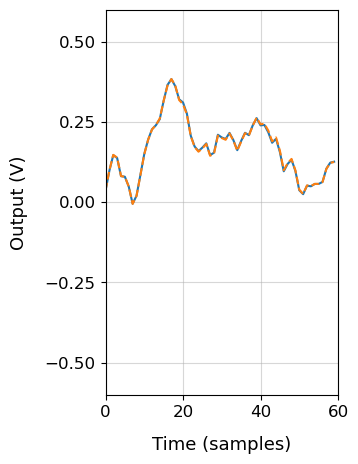

Fs: 44100.0
R: 43.6k


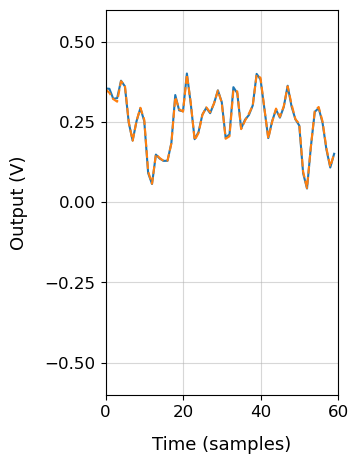

Fs: 48000.0
R: 55.9k


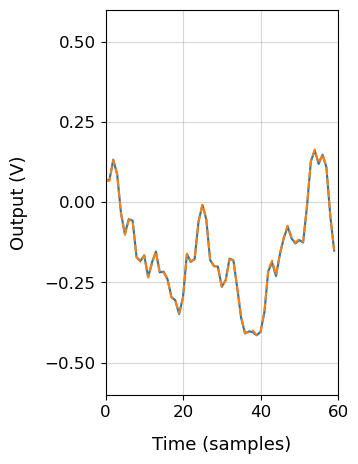

Fs: 48000.0
R: 10.3k


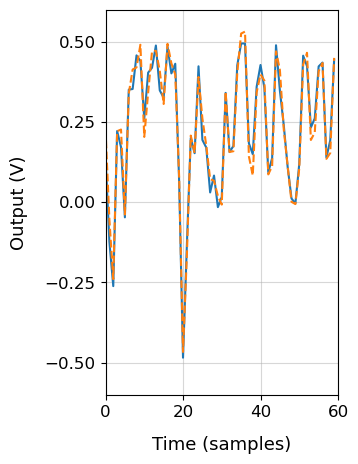

Fs: 48000.0
R: 70.6k


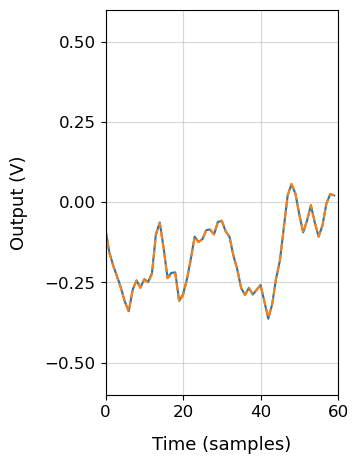

In [21]:
import matplotlib.ticker as ticker

real_batch_size = 60 + 127
train_dl, valid_dl = get_diodeClipper_dataloader(N=int(100e3), Fs=fs, num_up=num_up, num_down=num_down, r_begin=r_begin, r_end=r_end, batch_size=real_batch_size, plot=False)


def format_func(value, tick_number):
    # convert the number into k
    return f'{value / 1000}k'


i = 0
for x, y in valid_dl:
    x = x.squeeze()
    v_in = x[:, 0]
    r_in = x[:, 1]
    fs_in = x[:, 2]

    pred = model(v_in, r_in, fs_in)

    v_out = y.squeeze().numpy()
    pred = pred.detach().numpy()
    r_in = r_in.numpy()

    v_out = v_out[127:]
    pred = pred[127:]
    r_in = r_in[127:]

    print(f"Fs: {fs_in[0]}")
    print(f"R: {r_in[0]/1e3:.1f}k")

    fig, ax1 = plt.subplots(figsize=(3, 5))
    line1, = ax1.plot(v_out,  label='SPICE')
    line2, = ax1.plot(pred, label='2x16', linestyle='dashed')

    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
    ax1.set_ylim((-0.6, 0.6))
    ax1.set_ylabel('Output (V)', fontsize=13, labelpad=12)
    ax1.set_xlim((0, max(len(v_out), len(pred))))
    ax1.set_xlabel('Time (samples)', fontsize=13, labelpad=12)
    ax1.grid(True, alpha=0.5)
    ax1.tick_params(axis='both', which='major', labelsize=12)

    # ax2 = ax1.twinx()
    # line3, = ax1.plot(r_in, color='g', label='W Func')
    # ax2.set_ylabel('Resistor (Ω)', fontsize=13)
    # ax2.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
    # ax2.set_ylim((10e3, 100e3))
    # ax2.set_xlim((0, len(r_in)))

    # 在x = 63处绘制竖直虚线
    # ax1.axvline(x=skip_size-1, linestyle='dashed', color='gray')

    # 在竖直虚线上添加文字标签
    # ax1.text(63, ax1.get_ylim()[1], 'x = 63', color='gray', va='bottom', ha='center')

    # lines = [line1, line2, line3]
    # lines = [line1, line2]
    # labels = [line.get_label() for line in lines]
    # ax1.legend(lines, labels, loc='upper right')

    plt.savefig(f"1u1d_{fs_in[0]/1e3:.1f}k_{r_in[0]/1e3:.1f}k.pdf", dpi=300)

    # fig.tight_layout()
    plt.show()

    i += 1
    if i > 50:
        break